=== Inputs ===
Parachute Surface Area: 10.00 ft^2
Drone Weight: 2.00 lbs
Initial Altitude: 80.00 ft
Free Fall Time: 0.30 s
Parachute Fill Time: 1.20 s

=== Outputs ===
Max Speed: 13.75 ft/s
Max Absolute Acceleration: 32.44 ft/s² (1.01 Gs)
Final Speed At Impact: 11.37 ft/s
Impact Energy: 5.45 J


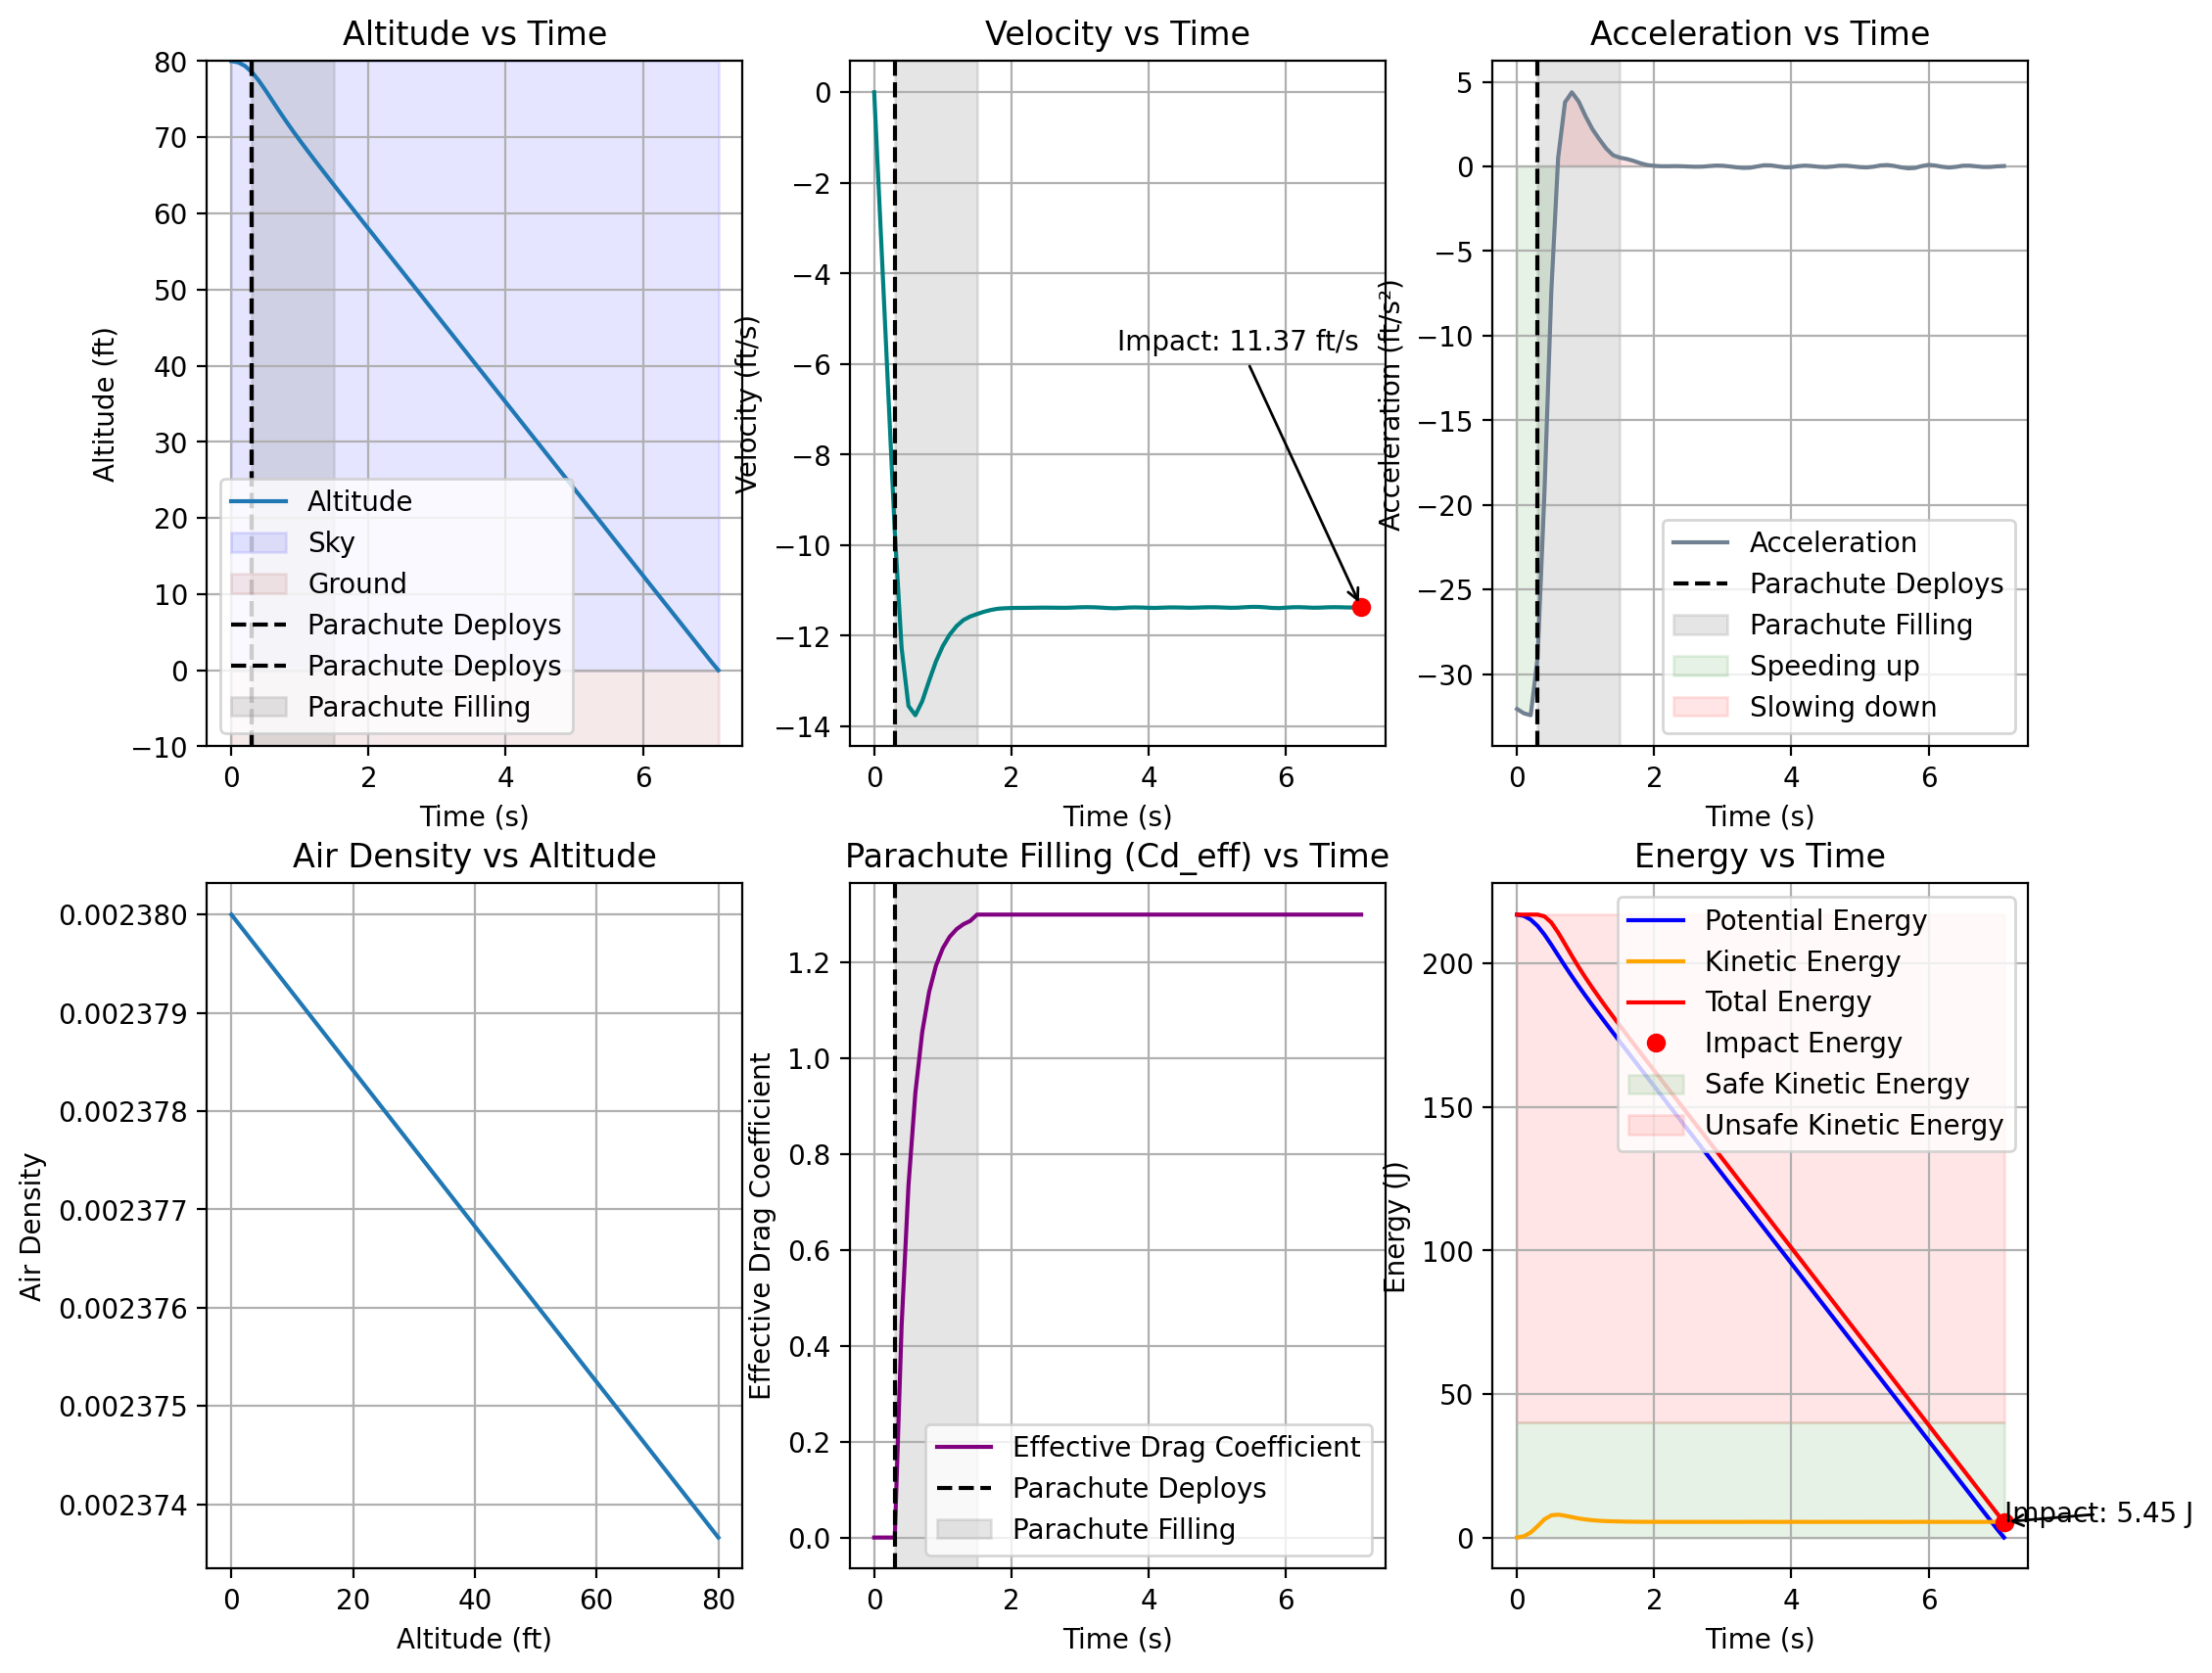

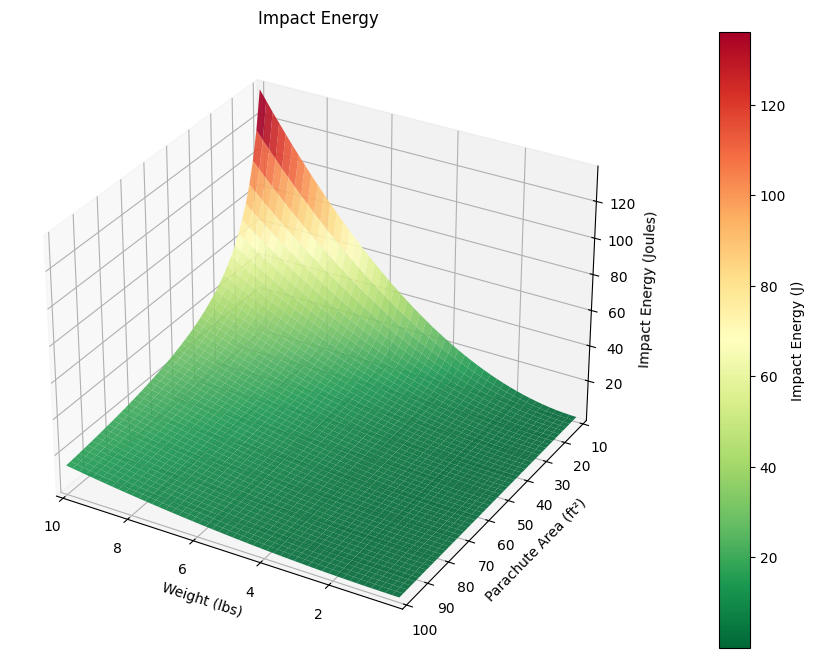

Progress: 0.00%
Progress: 4.00%
Progress: 8.00%
Progress: 12.00%
Progress: 16.00%
Progress: 20.00%
Progress: 24.00%
Progress: 32.00%
Progress: 36.00%
Progress: 40.00%
Progress: 44.00%
Progress: 48.00%
Progress: 52.00%
Progress: 60.00%
Progress: 64.00%
Progress: 68.00%
Progress: 72.00%
Progress: 76.00%
Progress: 80.00%
Progress: 84.00%
Progress: 88.00%
Progress: 92.00%
Progress: 96.00%


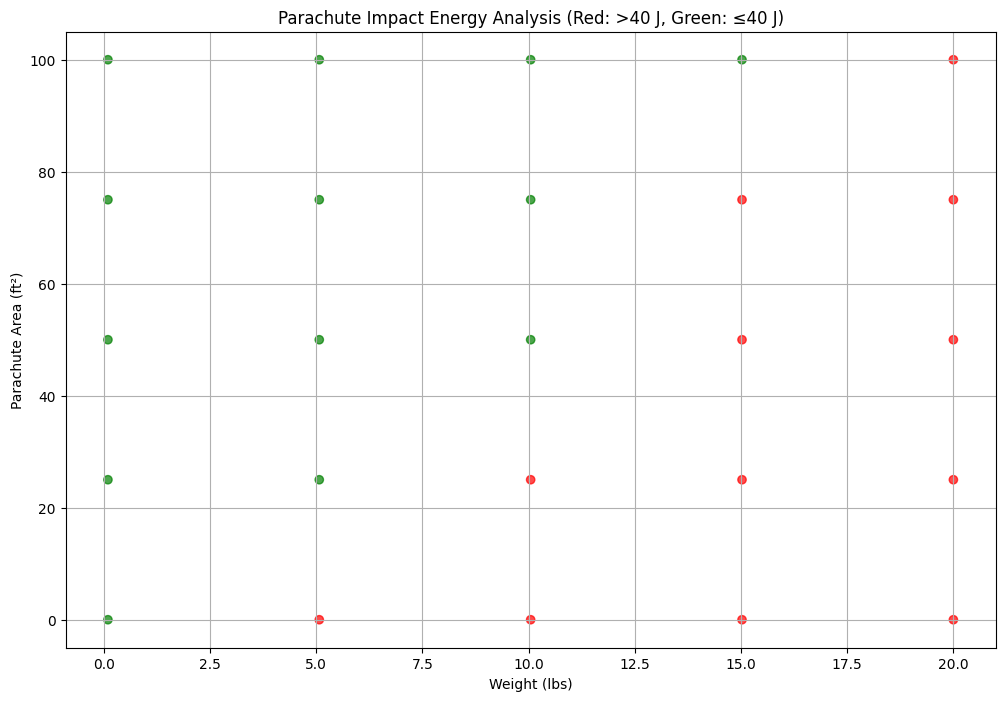

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Callable
from scipy.integrate import solve_ivp

@dataclass
class ParachuteParameters:
    """Class to hold parachute design parameters"""
    So: float  # Total canopy surface area (ft² or m²)
    Wt: float  # Total weight (lbs or N)
    Cdo: float  # Drag coefficient
    n: float   # Dimensionless fill constant

class ParachuteCalculator:
    """Class to perform parachute design calculations"""
    
    def __init__(self, params: ParachuteParameters):
        self.params = params
        # Standard sea level air density (slugs/ft³ or kg/m³)
        self.rho_sea_level = 0.00238  # slugs/ft³ (1.225 kg/m³) - at sea level and at 58°F (15°C)
        self.g = 32.2  # ft/s² (9.81 m/s²)
    
    def compute_drag_coefficient(self, t: float, free_fall_time: float, fill_time: float) -> float:
        """
        Compute the effective drag coefficient based on time.

        Parameters:
        - t: Current time (seconds)
        - free_fall_time: Time when parachute deployment begins (seconds)
        - fill_time: Duration for parachute to fully inflate (seconds)

        Returns:
        - Effective drag coefficient (dimensionless)
        """
        if t < free_fall_time:
            return 0  # No drag before parachute starts opening
        elif free_fall_time <= t < free_fall_time + fill_time:
            # Nonlinear increase in drag coefficient during inflation
            inflation_progress = (t - free_fall_time) / fill_time
            return self.params.Cdo * (1 - np.exp(-inflation_progress * 5))  # Exponential growth
        else:
            return self.params.Cdo  # Fully deployed after fill time
    def calculate_nominal_diameter(self) -> float:
        return np.sqrt((self.params.So / np.pi))
    
    def calculate_descent_rate_sea_level(self) -> float:
        return np.sqrt((2 * self.params.Wt) / 
                     (self.params.So * self.params.Cdo * self.rho_sea_level))
    
    def calculate_descent_rate_altitude(self, rho_altitude: float) -> float:
        vco = self.calculate_descent_rate_sea_level()
        return vco * np.sqrt(self.rho_sea_level / rho_altitude)
    
    def calculate_filling_distance(self, Dp: float) -> float:
        return self.params.n * Dp
    
    def simulate_descent(self, initial_altitude: float, 
                         free_fall_time: float = 0, 
                         fill_time: float = 1.0,  # Time for parachute to fully deploy
                         dt: float = 0.1, 
                         rho_altitude_func: Callable[[float], float] = None) -> Tuple[np.ndarray, ...]:
        """
        Simulate complete descent using `solve_ivp`.
        """
        if rho_altitude_func is None:
            rho_altitude_func = lambda h: self.rho_sea_level * np.exp(-h / 30000)
        
        def odes(t, y):
            h, v = y  # Unpack altitude and velocity
            if h <= 0:
                return [0, 0]  # Stop simulation when altitude is 0 or below
            
            rho = rho_altitude_func(h)  # Air density at altitude
            
            Fg = self.params.Wt  # Gravitational force in pounds-force (lbf)
            
            # Compute effective drag coefficient
            Cdo_eff = self.compute_drag_coefficient(t, free_fall_time, fill_time)
            
            # Drag force calculation
            Fd = 0.5 * rho * v**2 * Cdo_eff * self.params.So  # Drag force (lbf)
            
            # Net force
            Fnet = Fg - Fd  # Net force acting on the system (lbf)
            
            # Convert weight to mass (in slugs)
            mass = Fg / self.g  # Mass = Weight / g, where g = 32.2 ft/s²
            
            # Acceleration
            a = Fnet / mass  # Acceleration (ft/s²)
            
            return [v, -a]  # Velocity and acceleration

        
        y0 = [initial_altitude, 0]  # Initial altitude and velocity
        t_span = (0, 1000)  # Simulate for a max of 1000 seconds
        t_eval = np.arange(0, 1000, dt)  # Time intervals for evaluation
        
        solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
        
        time_points = solution.t
        altitudes = solution.y[0]
        velocities = solution.y[1]
        
        # Stop at ground
        ground_index = np.where(altitudes <= 0)[0]
        if len(ground_index) > 0:
            stop_index = ground_index[0]
            time_points = time_points[:stop_index + 1]
            altitudes = altitudes[:stop_index + 1]
            velocities = velocities[:stop_index + 1]
        
        accelerations = np.gradient(velocities, time_points)  # Approximate acceleration
        rho_values = [rho_altitude_func(h) for h in altitudes]
        
        return time_points, altitudes, velocities, accelerations, rho_values
    
    def plot_descent_simulation(self, Wt: float, initial_altitude: float, 
                                            free_fall_time: float = 0, 
                                            dt: float = 0.1,
                                            fill_time: float = 1.0,
                                            rho_altitude_func: Callable[[float], float] = None) -> None:
        times, altitudes, velocities, accelerations, rho_values = self.simulate_descent(
            initial_altitude, free_fall_time, fill_time, dt, rho_altitude_func)
        
        print(f"Initial Altitude: {initial_altitude:.2f} ft")
        print(f"Free Fall Time: {free_fall_time:.2f} s")
        print(f"Parachute Fill Time: {fill_time:.2f} s")
        print("\n=== Outputs ===")
        print(f"Max Speed: {max(abs(velocities)):.2f} ft/s")
        max_acceleration = max(abs(accelerations))  # Maximum absolute acceleration in ft/s²
        max_acceleration_gs = max_acceleration / self.g  # Convert ft/s² to Gs

        print(f"Max Absolute Acceleration: {max_acceleration:.2f} ft/s² ({max_acceleration_gs:.2f} Gs)")
        print(f"Final Speed At Impact: {abs(velocities[-1]):.2f} ft/s")

        FT_TO_M = 0.3048
        LB_TO_KG = 0.453592
        vco_mps = abs(velocities[-1]) * FT_TO_M
        mass_kg = Wt * LB_TO_KG
        impact_energy_joules = 0.5 * mass_kg * vco_mps**2
        print(f"Impact Energy: {impact_energy_joules:.2f} J")

        fig, axs = plt.subplots(2, 3, figsize=(12, 10), dpi=200)  # 2x2 layout

        ax1, ax2, ax3, ax4, ax5, ax6 = axs.flat

        # Altitude plot with sky and ground background
        ax1.plot(times, altitudes, label='Altitude')
        ax1.fill_between(times, 0, max(altitudes), color='blue', alpha=0.1, label='Sky')
        ax1.fill_between(times, -10, 0, color='brown', alpha=0.1, label='Ground')
        ax1.axvline(free_fall_time, color='black', linestyle='--', label='Parachute Deploys')
        ax1.axvline(free_fall_time, color='black', linestyle='--', label='Parachute Deploys')
        # Ensure the shaded region does not extend beyond the range of times
        parachute_fill_end = min(free_fall_time + fill_time, times[-1])
        ax1.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2, label='Parachute Filling')
        # add_gradient_fill(ax1, free_fall_time, free_fall_time + fill_time, min(velocities), max(velocities), cmap='gray', alpha=1)
        ax1.set_ylim(-10, max(altitudes))  # Set y-axis to start at -10
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Altitude (ft)')
        ax1.set_title('Altitude vs Time')
        ax1.legend()
        ax1.grid(True)

        # Velocity plot
        ax2.plot(times, velocities, label='Velocity', color='teal')
        ax2.axvline(free_fall_time, color='black', linestyle='--', label='Parachute Deploys')
        # Ensure the shaded region does not extend beyond the range of times
        parachute_fill_end = min(free_fall_time + fill_time, times[-1])
        ax2.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2, label='Parachute Filling')
        # Highlight impact energy point
        impact_time = times[-1]
        impact_velocity = velocities[-1]
        ax2.plot(impact_time, impact_velocity, 'ro', label="Impact Velocity")  # Red dot for impact energy
                # Annotate impact energy point
        ax2.annotate(f"Impact: {abs(impact_velocity):.2f} ft/s",
                    xy=(impact_time, impact_velocity),
                    xytext=(impact_time * 0.5, impact_velocity * 0.5),
                    arrowprops=dict(facecolor='black', arrowstyle="->"),
                    fontsize=10)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (ft/s)')
        ax2.set_title('Velocity vs Time')
        ax2.grid(True)

        # Acceleration plot with background color based on speeding up or slowing down
        ax3.plot(times, accelerations, label='Acceleration', color="slategray")
        ax3.axvline(free_fall_time, color='black', linestyle='--', label='Parachute Deploys')
        # Ensure the shaded region does not extend beyond the range of times
        parachute_fill_end = min(free_fall_time + fill_time, times[-1])
        ax3.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2, label='Parachute Filling')
        ax3.fill_between(times, accelerations, 0, where=(accelerations < 0), color='green', alpha=0.1, interpolate=True, label='Speeding up')
        ax3.fill_between(times, accelerations, 0, where=(accelerations > 0), color='red', alpha=0.1, interpolate=True, label='Slowing down')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Acceleration (ft/s²)')
        ax3.set_title('Acceleration vs Time')
        ax3.legend()
        ax3.grid(True)

        # Air density vs altitude plot
        ax4.plot(altitudes, rho_values, label='Air Density')
        ax4.set_xlabel('Altitude (ft)')
        ax4.set_ylabel('Air Density')
        ax4.set_title('Air Density vs Altitude')
        ax4.grid(True)


        # Calculate effective drag coefficient over time
        Cd_eff = [self.compute_drag_coefficient(t, free_fall_time, fill_time) for t in times]

        # Parachute Filling (Effective Drag Coefficient) plot
        ax5.plot(times, Cd_eff, label='Effective Drag Coefficient', color='purple')
        ax5.axvline(free_fall_time, color='black', linestyle='--', label='Parachute Deploys')
        # Ensure the shaded region does not extend beyond the range of times
        parachute_fill_end = min(free_fall_time + fill_time, times[-1])
        ax5.axvspan(free_fall_time, parachute_fill_end, color='gray', alpha=0.2, label='Parachute Filling')
        ax5.set_xlabel('Time (s)')
        ax5.set_ylabel('Effective Drag Coefficient')
        ax5.set_title('Parachute Filling (Cd_eff) vs Time')
        ax5.legend()
        ax5.grid(True)

        # Calculate mass of the drone
        mass = Wt / self.g  # Convert weight to mass (W = mg)

        # Calculate potential and kinetic energy over time
        potential_energy = mass * self.g * np.array(altitudes)
        kinetic_energy = 0.5 * mass * np.array(velocities) ** 2
        total_energy = potential_energy + kinetic_energy  # Total Energy for verification

        # Conversion factor from ft-lbs to Joules
        FT_LB_TO_JOULE = 1.3558179483

        # Convert energies to Joules
        potential_energy_joules = potential_energy * FT_LB_TO_JOULE
        kinetic_energy_joules = kinetic_energy * FT_LB_TO_JOULE
        total_energy_joules = total_energy * FT_LB_TO_JOULE

        # Energy vs. Time
        ax6.plot(times, potential_energy_joules, label="Potential Energy", color="blue")  # Green for potential energy
        ax6.plot(times, kinetic_energy_joules, label="Kinetic Energy", color="orange")  # Red for kinetic energy
        ax6.plot(times, total_energy_joules, label="Total Energy", color="red")  # Purple for total energy

        # Highlight impact energy point
        impact_time = times[-1]
        impact_energy = kinetic_energy_joules[-1]
        ax6.plot(impact_time, impact_energy, 'ro', label="Impact Energy")  # Red dot for impact energy

        # Annotate impact energy point
        ax6.annotate(f"Impact: {impact_energy:.2f} J",
                    xy=(impact_time, impact_energy),
                    xytext=(impact_time * 1, impact_energy ),
                    arrowprops=dict(facecolor='black', arrowstyle="->"),
                    fontsize=10)

        # Shaded regions for safe/unsafe impact energy
        ax6.fill_between(times, 0, 40, color='green', alpha=0.1, label='Safe Kinetic Energy')  # Green for safe energy
        ax6.fill_between(times, 40, max(total_energy_joules), color='red', alpha=0.1, label='Unsafe Kinetic Energy')  # Red for unsafe energy

        # Set labels, title, legend, and grid
        ax6.set_title("Energy vs Time")
        ax6.set_xlabel("Time (s)")
        ax6.set_ylabel("Energy (J)")
        ax6.legend()
        ax6.grid(True)  # Light gray dashed grid for readability
        plt.show()



# Example usage
def example_calculation():
    # Example parameters (using imperial units)
    params = ParachuteParameters(
        So=10,    # ft²
        Wt=2,    # lbs (Matrice 3000 with single gimbal and 2 batteries is 6.47 kg)
        Cdo=1.3,   # typical value for round parachutes
        n=3        # typical value for round parachutes
    )
    
    calculator = ParachuteCalculator(params)
    

    # Calculate parameters
    Do = calculator.calculate_nominal_diameter()
    vco = calculator.calculate_descent_rate_sea_level()  # descent rate in ft/s


    # Calculate impact energy in joules
    # impact_energy_joules = 0.5 * mass_kg * vco_mps**2

    # Print results
    print("=== Inputs ===")
    print(f"Parachute Surface Area: {params.So:.2f} ft^2")
    print(f"Drone Weight: {params.Wt:.2f} lbs")

    # print(f"Nominal Diameter: {Do:.2f} ft")
    # print(f"Sea Level Descent Rate: {vco:.2f} ft/s")

    # Run and plot complete descent simulation
    calculator.plot_descent_simulation(Wt=params.Wt, initial_altitude=80, free_fall_time=0.3, dt=0.1, fill_time=1.2)  # 5000 ft initial altitude

    # params = ParachuteParameters(
    #     So=10,    # ft²
    #     Wt=2,    # lbs (Matrice 3000 with single gimbal and 2 batteries is 6.47 kg)
    #     Cdo=1.3,   # typical value for round parachutes
    #     n=3        # typical value for round parachutes
    # )
    
    # calculator = ParachuteCalculator(params)
    # # Example call:
    # plot_drag_force_surface(calculator, altitude_range=(0, 1000), velocity_range=(-200, 0))


    # params = ParachuteParameters(So=10, Wt=2, Cdo=1.3, n=3)
    # calculator = ParachuteCalculator(params)
    # plot_vector_field(calculator, altitude_range=(0, 1000), velocity_range=(-200, 0))

    # Define ranges and parameters for the surface plot
    weight_range = (0.1, 10)  # lbs
    area_range = (10, 100)   # ft²
    initial_altitude = 400    # ft
    Cdo = 1.3                 # Drag coefficient

    impact_energy_surface(weight_range, area_range, initial_altitude, Cdo)

    weight_range = np.linspace(0.1, 20, 5)  # Range of weights (lbs)
    area_range = np.linspace(0.1, 100, 5)    # Range of parachute areas (ft²)
    free_fall_time = 1
    fill_time = 1
    # Re-run the simulation for the full descent and impact energy
    initial_altitude = 400  # Set an initial altitude for all simulations (e.g., 2000 ft)
    dt = 0.1  # Time step for the simulation

    impact_energies = []
    colors = []
    weights = []
    areas = []

    total_iterations = len(weight_range) * len(area_range)  # Total number of iterations
    current_iteration = 0

    for weight in weight_range:
        # print(weight)
        for area in area_range:
            # print(area)
            params = ParachuteParameters(
                So=area,    # ft²
                Wt=weight,  # lbs
                Cdo=1.3,    # typical value for round parachutes
                n=3         # typical value for round parachutes
            )
            calculator = ParachuteCalculator(params)
            
            # Run the full descent simulation
            _, _, velocities, _, _= calculator.simulate_descent(initial_altitude, free_fall_time, dt, fill_time)
            
            # Get the final velocity (last element of the velocity array)
            final_velocity = abs(velocities[-1])  # Ensure positive magnitude
            
            FT_TO_M = 0.3048  # feet to meters
            LB_TO_KG = 0.453592  # pounds to kilograms
            # Calculate the impact energy
            mass_kg = weight * LB_TO_KG  # Convert weight to mass
            final_velocity_mps = final_velocity * FT_TO_M  # Convert ft/s to m/s
            impact_energy_joules = 0.5 * mass_kg * final_velocity_mps**2
            # print("Final velocity")
            # print(final_velocity)
            # print("Impact energy")
            # print(impact_energy_joules)
            # Store results
            weights.append(weight)
            areas.append(area)
            impact_energies.append(impact_energy_joules)
            colors.append('red' if impact_energy_joules > 40 else 'green')

            # Calculate percentage complete
            percent_complete = (current_iteration / total_iterations) * 100
            if(percent_complete % 1 == 0):
                print(f"Progress: {percent_complete:.2f}%")
            current_iteration += 1

            # Print percentage complete


    # Create scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(weights, areas, c=colors, alpha=0.7, marker='o')  # Use dots
    plt.xlabel('Weight (lbs)')
    plt.ylabel('Parachute Area (ft²)')
    plt.title('Parachute Impact Energy Analysis (Red: >40 J, Green: ≤40 J)')
    plt.grid(True)
    plt.show()
from mpl_toolkits.mplot3d import Axes3D

def plot_drag_force_surface(calculator, altitude_range, velocity_range, fill_time=1.0, free_fall_time=0):
    altitudes = np.linspace(*altitude_range, 500)
    velocities = np.linspace(*velocity_range, 500)
    A, V = np.meshgrid(altitudes, velocities)
    DragForce = np.zeros_like(A)
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            h, v = A[i, j], V[i, j]
            rho = calculator.rho_sea_level * np.exp(-h / 30000)  # Approximate air density
            Cdo_eff = calculator.compute_drag_coefficient(free_fall_time, free_fall_time, fill_time)
            DragForce[i, j] = 0.5 * rho * v**2 * Cdo_eff * calculator.params.So
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(A, V, DragForce, cmap='viridis', alpha=0.9)
    ax.set_title("3D Surface Plot of Drag Force")
    ax.set_xlabel("Altitude (ft)")
    ax.set_ylabel("Velocity (ft/s)")
    ax.set_zlabel("Drag Force (lbf or N)")
    plt.show()
def plot_vector_field(calculator, altitude_range, velocity_range, fill_time=1.0, free_fall_time=0):
    altitudes = np.linspace(*altitude_range, 20)  # Fine resolution
    velocities = np.linspace(*velocity_range, 20)
    A, V = np.meshgrid(altitudes, velocities)
    DragForce = np.zeros_like(A)
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            h, v = A[i, j], V[i, j]
            rho = calculator.rho_sea_level * np.exp(-h / 30000)  # Approximate air density
            Cdo_eff = calculator.compute_drag_coefficient(free_fall_time, free_fall_time, fill_time)
            DragForce[i, j] = 0.5 * rho * v**2 * Cdo_eff * calculator.params.So
    
    magnitude = np.sqrt(np.zeros_like(DragForce)**2 + (-DragForce)**2)
    
    plt.figure(figsize=(10, 7))
    plt.quiver(A, V, np.zeros_like(DragForce), -DragForce, scale=1e4, scale_units='xy', 
               color='blue', alpha=0.7)
    plt.title("Vector Field of Drag Forces")
    plt.xlabel("Altitude (ft)")
    plt.ylabel("Velocity (ft/s)")
    plt.grid(True)
    plt.show()
def plot_streamlines(calculator, altitude_range, velocity_range, fill_time=1.0, free_fall_time=0):
    altitudes = np.linspace(*altitude_range, 50)
    velocities = np.linspace(*velocity_range, 50)
    A, V = np.meshgrid(altitudes, velocities)
    DragForce = np.zeros_like(A)
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            h, v = A[i, j], V[i, j]
            rho = calculator.rho_sea_level * np.exp(-h / 30000)  # Approximate air density
            Cdo_eff = calculator.compute_drag_coefficient(free_fall_time, free_fall_time, fill_time)
            DragForce[i, j] = 0.5 * rho * v**2 * Cdo_eff * calculator.params.So
    
    plt.figure(figsize=(10, 7))
    plt.streamplot(A, V, np.zeros_like(DragForce), -DragForce, color=-DragForce, cmap='viridis')
    plt.title("Streamline Plot of Drag Forces")
    plt.xlabel("Altitude (ft)")
    plt.ylabel("Velocity (ft/s)")
    plt.colorbar(label="Drag Force Magnitude")
    plt.grid(True)
    plt.show()

def impact_energy_surface(weight_range, area_range, initial_altitude, Cdo):
    weights = np.linspace(*weight_range, 50)  # lbs
    areas = np.linspace(*area_range, 50)     # ft²
    W, A = np.meshgrid(weights, areas)
    impact_energies = np.zeros_like(W)
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            params = ParachuteParameters(So=A[i, j], Wt=W[i, j], Cdo=Cdo, n=3)
            calculator = ParachuteCalculator(params)
            _, _, velocities, _, _ = calculator.simulate_descent(initial_altitude, free_fall_time=0.3, fill_time=1)
            if velocities.size > 0:
                final_velocity = abs(velocities[-1])

                FT_TO_M = 0.3048  # feet to meters
                LB_TO_KG = 0.453592  # pounds to kilograms

                mass_kg = W[i, j] * LB_TO_KG
                velocity_mps = final_velocity * FT_TO_M
                impact_energies[i, j] = 0.5 * mass_kg * velocity_mps**2

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Flip Altitude and Velocity axes
    ax.plot_surface(W, A, impact_energies, cmap='RdYlGn_r', edgecolor='none', alpha=0.9)

    # Customize axis directions
    ax.set_xlim(weight_range[1], weight_range[0])  # Reverse weight axis
    ax.set_ylim(area_range[1], area_range[0])      # Reverse area axis
    
    # Axis labels
    ax.set_title("Impact Energy")
    ax.set_xlabel("Weight (lbs)")
    ax.set_ylabel("Parachute Area (ft²)")
    ax.set_zlabel("Impact Energy (Joules)")
    
    # Add color bar for gradient
    mappable = plt.cm.ScalarMappable(cmap='RdYlGn_r')
    mappable.set_array(impact_energies)
    cbar = fig.colorbar(mappable, ax=ax, pad=0.1)
    cbar.set_label("Impact Energy (J)")

    plt.show()



if __name__ == "__main__":
    example_calculation()